In [1]:
from ROOT  import * #En el ICN no funciona

Welcome to JupyROOT 6.28/04


# Llenar un histograma y hacer fit usando pyROOT

 FCN=116.6 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=3.06448e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.81582e+01   1.75014e+00   7.43780e-03  -3.39899e-04
   2  Mean         9.63500e-03   1.44047e-02   7.62630e-05  -1.70389e-02
   3  Sigma        9.94926e-01   1.08268e-02   1.52413e-05   6.11024e-02


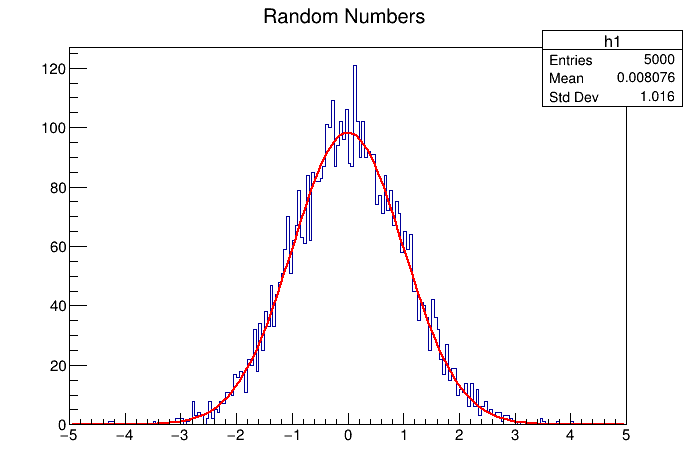

In [2]:
h1=TH1F("h1", "Random Numbers",200,-5,5)

data=h1.FillRandom("gaus")

c1=TCanvas()

h1.Fit("gaus")

h1.Draw()
c1.Draw()

### Obtener mas resultados acerca del ajuste

In [3]:
f = h1.GetFunction("gaus")
print(f.GetNDF())           # Numero de grados de libertad
print(f.GetChisquare())     # Chisquare
print(f.GetProb())          # 

127
116.59974682218747
0.7353736867937091


# Utilizando datos de una imagen FITS

In [4]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

import sys

# sys.path.insert(0, '/home/mauricio/Software/Serial_Register_Events_Detection')
# from ReconLib import *

plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})


## Imágenes de NSAMP_1

Filename: /home/bruce/Documents/imagenesMicrochip/14JUN23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_1_NROW_700_NCOL_700_EXPOSURE_1200_NBINROW_1_NBINCOL_1_img_7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 700)   float32   
  1                1 ImageHDU       164   (700, 700)   float32   
  2                1 ImageHDU       164   (700, 700)   float32   
  3                1 ImageHDU       164   (700, 700)   float32   
None
----------------


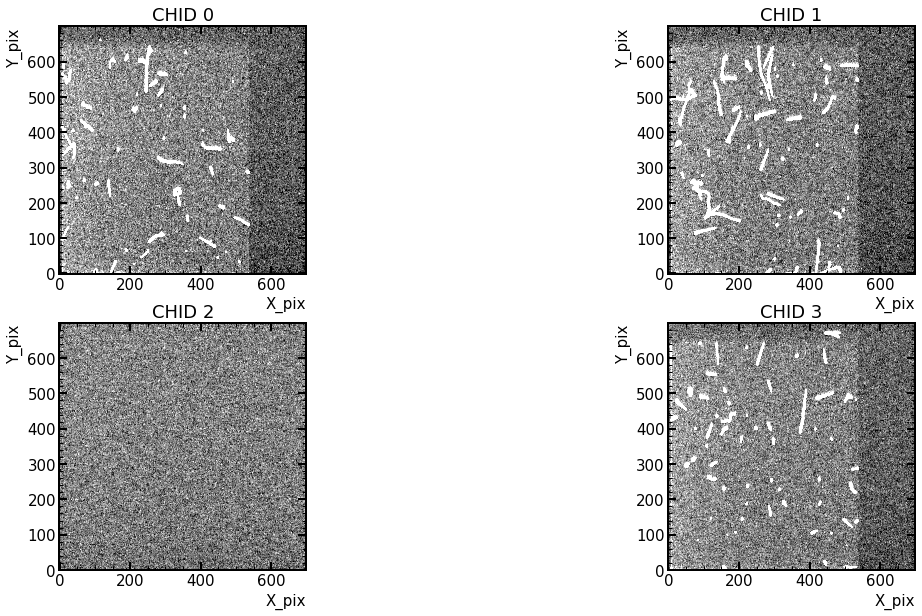

In [5]:
# path='/home/mauricio/datosFits/spuriousCharge/Microchip/14AUG23/proc_skp_module24_MITLL01_externalVr-4_Vv2_T140__NSAMP225_NROW650_NCOL700_EXPOSURE0_NBINROW1_NBINCOL1_img109.fits'

path =  '/home/bruce/Documents/imagenesMicrochip/14JUN23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_1_NROW_700_NCOL_700_EXPOSURE_1200_NBINROW_1_NBINCOL_1_img_7.fits'


hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=-800,vmax=800,cmap='gray')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

In [6]:
extension = 1
Bins = 500
ratio_keV = 0.0037

active_area = hdu_list[extension-1].data[:, :550]
header = hdu_list[0].header

# print(header)

oScan = hdu_list[extension-1].data[:,550:]
hist , bins_edges = np.histogram(oScan.flatten(), bins = Bins)
offset = bins_edges[np.argmax(hist)]
expgain = [227, 220.4, 94.72, 197.7]

Overscan_plane = oScan - offset


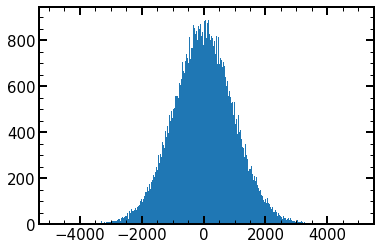

In [7]:
histo, bins,_ = plt.hist(Overscan_plane.flatten(), bins=500)

### La distribucion de pixeles que esperamos es una doble gaussiana, de la cual tenemos una curva que hemos utilizado anteriormente y que podemos definir en ROOT para poder utilizarla en el fit

In [8]:
# definition and parameters of gaussian2: 
# def gaussian2(x,m,s,g,a1,a2): #data, mean = [0] , sigma = [1], gain =[2], height1 = [3], heigth2 = [4]
# in root format: [3]*exp(-1/2*((x-[0])/[1])^2)+[4]*exp(-1/2*((x-[0]-[2])/[1])^2)

# def gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
#     return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)    #esta funcion la usé en python para un ajuste de dos gausianas, 
                                                                          # solo es necesario escribir la funcion de manera compatible con ROOT

# https://root.cern.ch/root/htmldoc/guides/users-guide/FittingHistograms.html
#data, mean = [0] , sigma = [1], gain =[2], height1 = [3], heigth2 = [4]

def gaussian(x, a, mean, sigma): 
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

## Definicion de la variable TFunction 
# fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-200,700,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
fgaus2 = TF1("fgauss","gaus",-4000,4000,3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)



Parameters of the Gaussian Fit
Hight:  679.2671138686754  +-  2.6477461052833027
Mean:  0.7693960249250172  +-  3.0391768903438683
Sigma:  980.6592561748943  +-  2.3273176377866207 

chiSquare= 633.9626927517636
NDegrees of Freedom: 476
chiSquare / NDF : 1.3318543965373184 

 FCN=633.963 FROM MIGRAD    STATUS=CONVERGED      64 CALLS          65 TOTAL
                     EDM=8.03573e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.79267e+02   2.64775e+00   2.58733e-02  -1.72956e-05
   2  Mean         7.69396e-01   3.03918e+00   3.73914e-02   7.70296e-06
   3  Sigma        9.80659e+02   2.32732e+00   7.67562e-06   1.15949e-01


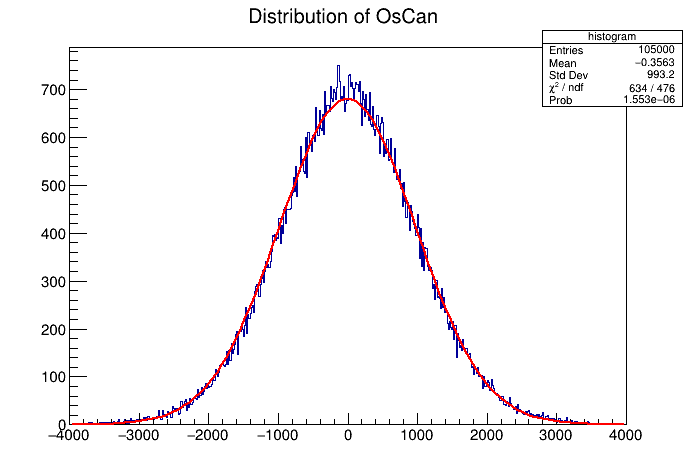

In [9]:
h3=TH1F("histogram", "Distribution of OsCan",500, -4000,4000)

for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
        #print(pixel_value)

fgaus2.SetParameters(800,10,100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2)

c3=TCanvas()

h3.Draw()
c3.Draw()
fgaus2.Draw("same")
gStyle.SetOptFit(1100)
gStyle.SetPadGridX (True)
# fgaus2.Draw('Quiet')


print('Parameters of the Gaussian Fit')
print('Hight: ', fgaus2.GetParameters()[0], ' +- ', fgaus2.GetParError(0))
print('Mean: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Sigma: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2), '\n')



print("chiSquare= "+str(fgaus2.GetChisquare()))
print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF(), '\n')

## Imágenes de NSAMP_324

Filename: /home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_104.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 650)   float32   
  1                1 ImageHDU       164   (700, 650)   float32   
  2                1 ImageHDU       164   (700, 650)   float32   
  3                1 ImageHDU       164   (700, 650)   float32   
None
----------------


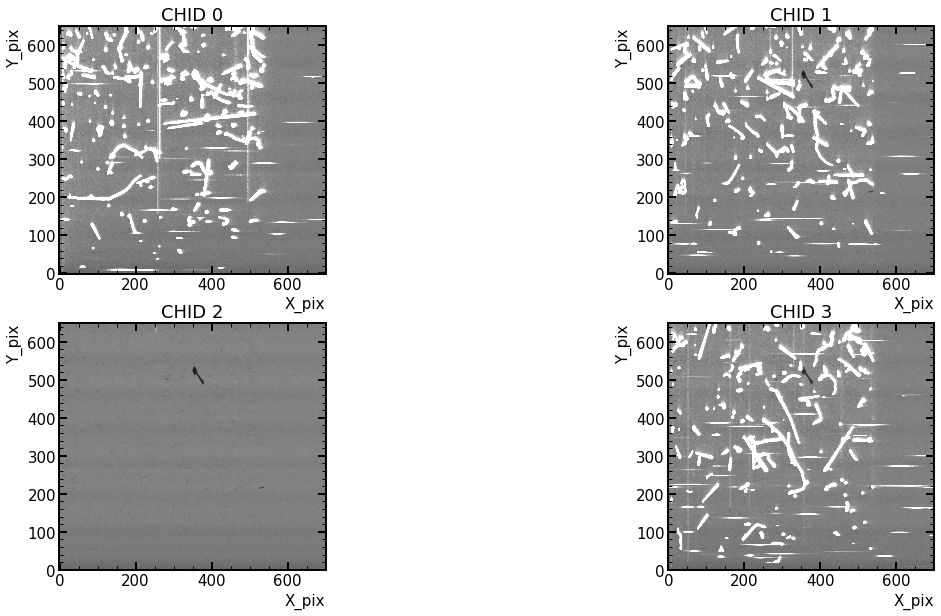

In [10]:
# path = '/home/bruce/Documents/imagenesMicrochip/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_25.fits'

# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits'
path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_104.fits'

# path = '/home/bruce/Documents/Programas/images/ENE2024/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_200.fits'


hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=-800,vmax=800,cmap='gray')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()


In [11]:
Bins = 500
extension = 2
# plt.imshow(hdu_list[0].data[:, 550:], vmin = 0, vmax = 80000, origin = 'lower')
Overscan = hdu_list[extension - 1].data[:, 550:]
active_area = hdu_list[extension - 1].data[:, :550]

# print('Dimensiones Oscan: ', Overscan.shape)
oscan_x = Overscan.shape[1]
oscan_y = Overscan.shape[0]


### Dimensiones de Active Area
# print('Dimensiones ActA: ', active_area.shape)
acta_x = active_area.shape[1]
acta_y = active_area.shape[0]

mean_rows_value = []
for element in np.arange(0, oscan_y):
    row = Overscan[element: element +1, 0: oscan_x]
    num_row = element + 1
    # plt.imshow(row, origin='lower')
    # plt.show()
    # print(row.shape)
    # print(type(row))
    # print(row.sum()/row.shape[1])
    mean_value = np.median(row)
    mean_rows_value.append([mean_value])
    # print((num_row, mean_value))

### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
true_active_area = active_area - mean_rows_value
true_Oscan = Overscan

min_oScan = np.min(true_Oscan)

Offset:  8767.61


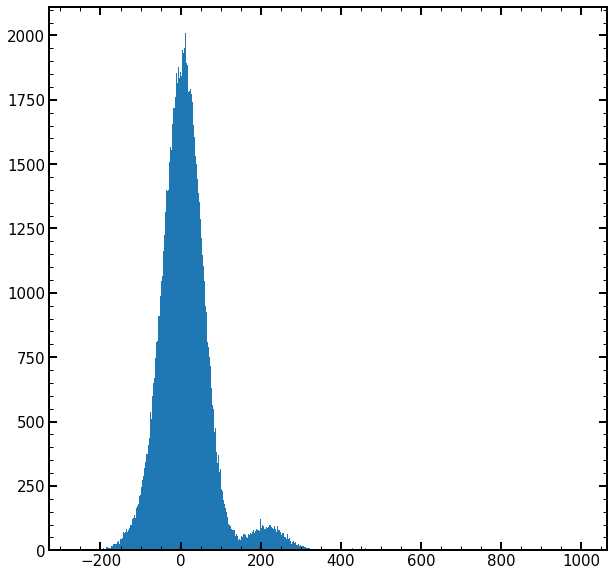

In [12]:
hist , bins_edges = np.histogram(true_Oscan.flatten(), bins = Bins, range=(min_oScan, 18000))
offset = bins_edges[np.argmax(hist)]
print('Offset: ', offset)


Overscan_plane = true_Oscan - offset

fig_all, axs_all = plt.subplots(1, 1, figsize=(10, 10))

min_oScan_plane = np.min(Overscan_plane)

## Generamos el histograma de los pixeles del oScan especificando el rango
bin_heights, bin_borders, _ = axs_all.hist(Overscan_plane.flatten(), bins= Bins, range = (min_oScan_plane, 1000) , label="Pixeles del Overscan")

plt.show()

In [13]:
# def gaussian2(x,m,s,g,a1,a2): #data, mean = [0] , sigma = [1], gain =[2], height1 = [3], heigth2 = [4]
# in root format: [3]*exp(-1/2*((x-[0])/[1])^2)+[4]*exp(-1/2*((x-[0]-[2])/[1])^2)

def gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
    return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)    #esta funcion la usé en python para un ajuste de dos gausianas, 
                                                                          # solo es necesario escribir la funcion de manera compatible con ROOT

# https://root.cern.ch/root/htmldoc/guides/users-guide/FittingHistograms.html
#data, mean = [0] , sigma = [1], gain =[2], height1 = [3], heigth2 = [4]

## Definicion de la variable TFunction 
fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)

Parameters of the Doble-Gaussian Fit
Mean:  4.803915522178377  +-  0.17473738602972258
Sigma:  47.74982980315283  +-  0.13762368095976366
Gain:  213.0331895112298  +-  1.0589331196422298 

 FCN=2142.49 FROM MIGRAD    STATUS=CONVERGED     603 CALLS         604 TOTAL
                     EDM=3.52169e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.80392e+00   1.74737e-01   3.86098e-03  -8.27110e-04
   2  p1           4.77498e+01   1.37624e-01   2.36337e-03   1.94575e-03
   3  p2           2.13033e+02   1.05893e+00   2.32542e-02   5.88918e-06
   4  p3           1.50651e+02   6.34887e-01   1.14443e-02   1.52587e-03
   5  p4           5.84951e+00   1.10731e-01   2.42826e-03  -8.94663e-04


Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram4 (Potential memory leak).


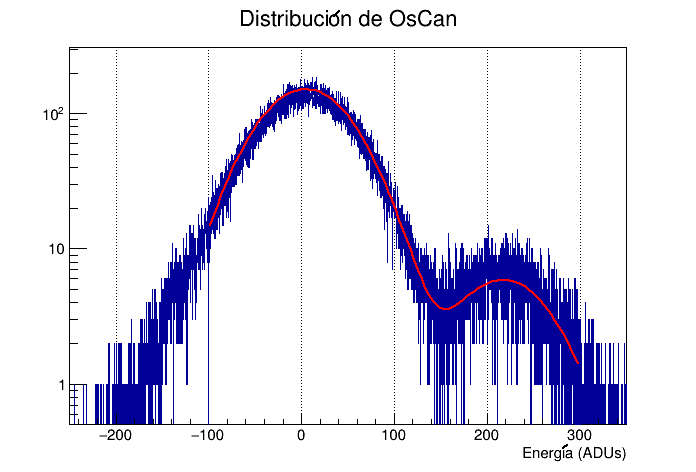

In [20]:
h3=TH1F("histogram", "Distribution of OsCan",2000,-100,300)
h4=TH1F("histogram4", "Distribuci#acute{o}n de OsCan",3500,-250,350)

for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
        #print(pixel_value)

for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h4.Fill(pixel_value)
        #print(pixel_value)

fgaus2.SetParameters(0,10,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2)
h3.SetStats(0)
h4.SetStats(0)
h4.GetXaxis().SetTitle("Energ#acute{i}a (ADUs)")


c3=TCanvas()

h4.Draw()
h3.Draw("same")
c3.Draw("same")
# fgaus2.Draw("same")
gStyle.SetOptFit(1100)
gStyle.SetPadGridX (True)
gPad.SetLogy(1)
# gPad.SetLogx(1)
# fgaus2.Draw('Quiet')


print('Parameters of the Doble-Gaussian Fit')
print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2), '\n')



# print("chiSquare= "+str(fgaus2.GetChisquare()))
# print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
# print("chiSquare/NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF(), '\n')